In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
import os, math, cv2, glob, random, time
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from keras.optimizers import SGD, Adam
from keras.callbacks import LearningRateScheduler
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Reshape, Flatten, concatenate, BatchNormalization, Conv2DTranspose, LeakyReLU, Dropout


train_dataset_path = '../input/10-monkey-species/training/training'
validation_dataset_path  = '../input/10-monkey-species/validation/validation'

# width 550 height 367
IMAGE_HEIGHT      = 64
IMAGE_WIDTH       = 64
IMAGE_SIZE        = (IMAGE_HEIGHT, IMAGE_WIDTH)

CATEGORIES        = os.listdir(train_dataset_path)
# len all images 1370
ALL_DATA_LENGTH   = 1370
INPUT_DATA_LENGTH = 1000
INPUT_DENSE       = IMAGE_HEIGHT * IMAGE_WIDTH * 3
BATCH_SIZE        = 32 
tf.__version__

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

'1.14.0'

In [2]:
def get_image_to_path():
    idxIn = 0; namesIn = [];
    imagesIn = np.zeros((ALL_DATA_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    for path_im in [train_dataset_path, validation_dataset_path]:
        for category in CATEGORIES:
            path = f'{path_im}/{category}/'
            class_id = CATEGORIES.index(category)
            for image in os.listdir(path):
                img = Image.open(os.path.join(path, image))
                w = img.size[0]
                h = img.size[1]
                sz = np.min((w,h))
                a=0; b=0
                if w<h: b = (h-sz)//2
                else: a = (w-sz)//2
                img = img.crop((0+a, 0+b, sz+a, sz+b))  
                img = img.resize((IMAGE_HEIGHT, IMAGE_WIDTH), Image.ANTIALIAS)   
                imagesIn[idxIn,:,:,:] = np.asarray(img)
                namesIn.append(os.path.join(path, image))
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    return imagesIn, namesIn
    
data_images, data_names = get_image_to_path()  

In [3]:
# BUILD DISCRIMINATIVE NETWORK
monkey = Input((INPUT_DENSE,))
monkeyName = Input((INPUT_DATA_LENGTH,))
x = Dense(INPUT_DENSE, activation='sigmoid')(monkeyName) 
x = Reshape((2,INPUT_DENSE,1))(concatenate([monkey,x]))
x = Conv2D(1,(2,1),use_bias=False,name='conv')(x)
discriminated = Flatten()(x)

# COMPILE
discriminator = Model([monkey,monkeyName], discriminated)
discriminator.get_layer('conv').trainable = False
discriminator.get_layer('conv').set_weights([np.array([[[[-1.0 ]]],[[[1.0]]]])])
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

# DISPLAY ARCHITECTURE
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 12288)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12288)        1241088     input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 24576)        0           input_1[0][0]                    
                                                                 dense_1[0][0]                    
__________

In [4]:
# TRAINING DATA
train_y = (data_images[:INPUT_DATA_LENGTH,:,:,:]/255.).reshape((-1,INPUT_DENSE))
train_X = np.zeros((INPUT_DATA_LENGTH,INPUT_DATA_LENGTH))
for i in range(INPUT_DATA_LENGTH): train_X[i,i] = 1
zeros = np.zeros((INPUT_DATA_LENGTH,INPUT_DENSE))

# TRAIN NETWORK
lr = 0.5
for k in range(5):
    annealer = LearningRateScheduler(lambda x: lr)
    h = discriminator.fit([zeros,train_X],
                          train_y,
                          epochs=5,
                          batch_size=BATCH_SIZE,
                          callbacks=[annealer],
                          verbose=0)
    print('Epoch',(k+1)*10,'/30 - loss =',h.history['loss'][-1] )
    if h.history['loss'][-1]<0.533: lr = 0.1

Epoch 10 /30 - loss = 0.5602160501480102
Epoch 20 /30 - loss = 0.5385048627853394
Epoch 30 /30 - loss = 0.5348974776268005
Epoch 40 /30 - loss = 0.533777003288269
Epoch 50 /30 - loss = 0.5333985280990601


In [5]:
del train_X, train_y, data_images

Discriminator Recalls from Memory Monkey


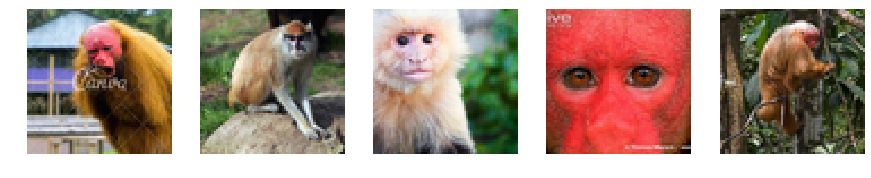

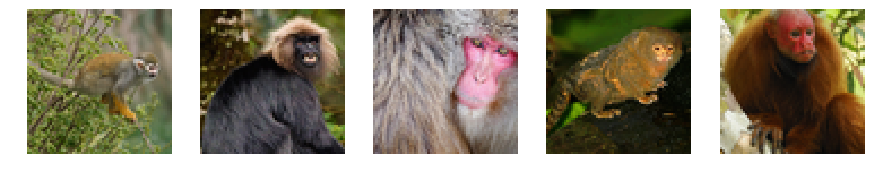

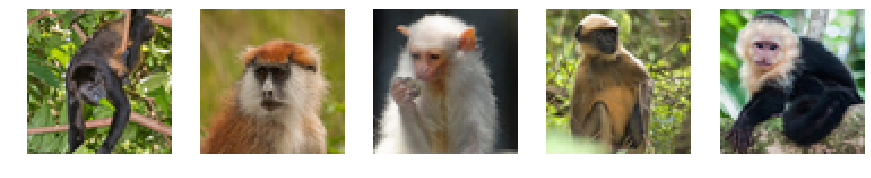

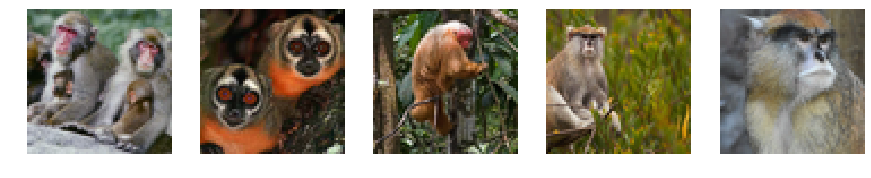

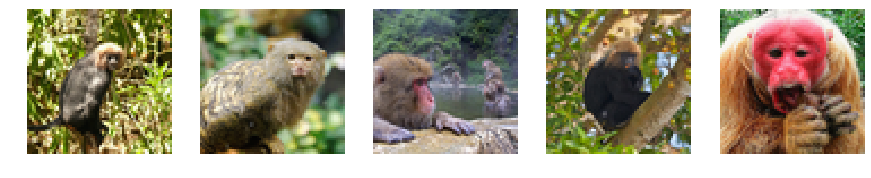

In [6]:
print('Discriminator Recalls from Memory Monkey')    
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((INPUT_DATA_LENGTH))
        xx[np.random.randint(INPUT_DATA_LENGTH)] = 1
        plt.subplot(1,5,j+1)
        img = discriminator.predict([zeros[0,:].reshape((-1,INPUT_DENSE)),xx.reshape((-1,INPUT_DATA_LENGTH))]).reshape((-1,64,64,3))
        img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

In [7]:
# BUILD GENERATOR NETWORK
BadMemory = True

if BadMemory:
    seed = Input((INPUT_DATA_LENGTH,))
    x = Dense(int(INPUT_DENSE/6))(seed)
    x = LeakyReLU()(x)

    x = Reshape((8,8,32))(x)

    x = Conv2DTranspose(128, (3, 3), padding='same', strides=(2, 2))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    
    x = Conv2DTranspose(64, (2, 2), padding='same', strides=(2, 2))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    
    x = Conv2DTranspose(32, (2, 2), padding='same', strides=(2, 2))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    
    x = Conv2DTranspose(3, (1, 2), padding='same')(x)
    x = LeakyReLU()(x)
    generated = Flatten()(x)
else:
    seed = Input((INPUT_DATA_LENGTH,))
    x = Dense(INPUT_DENSE)(seed)
    generated = LeakyReLU()(x)

# COMPILE
generator = Model(seed, [generated,Reshape((INPUT_DATA_LENGTH,))(seed)])

# DISPLAY ARCHITECTURE
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2048)         206848      input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 2048)         0           dense_2[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 8, 8, 32)     0           leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
conv2d_tra

In [8]:
# BUILD GENERATIVE ADVERSARIAL NETWORK
discriminator.trainable=False    
gan_input = Input(shape=(INPUT_DATA_LENGTH,))
x = generator(gan_input)
gan_output = discriminator(x)

# COMPILE GAN
gan = Model(gan_input, gan_output)
gan.get_layer('model_1').get_layer('conv').set_weights([np.array([[[[-1 ]]],[[[255.]]]])])
gan.compile(optimizer=Adam(2), loss='mean_squared_error')

# DISPLAY ARCHITECTURE 
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 12288), (Non 285987      input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 12288)        1241090     model_2[1][0]                    
                                                                 model_2[1][1]                    
Total params: 1,527,077
Trainable params: 285,539
Non-trainable params: 1,241,538
__________________________________________________________________________________________________


Epoch 1 /15 - loss = 13121.762109375


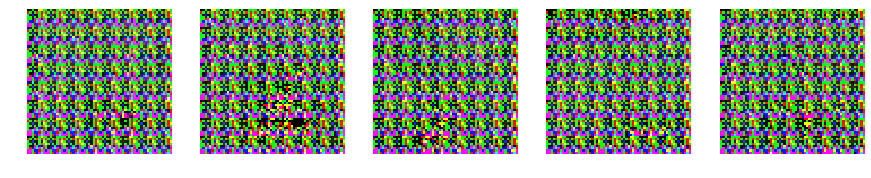

Epoch 2 /15 - loss = 12514.45421875


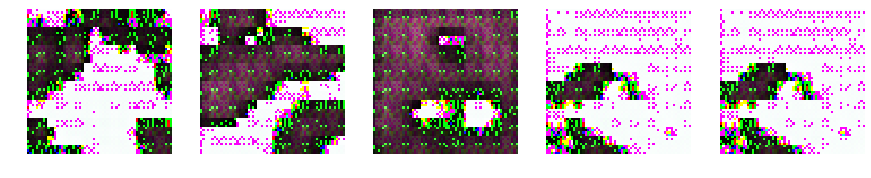

Epoch 3 /15 - loss = 10349.613359375


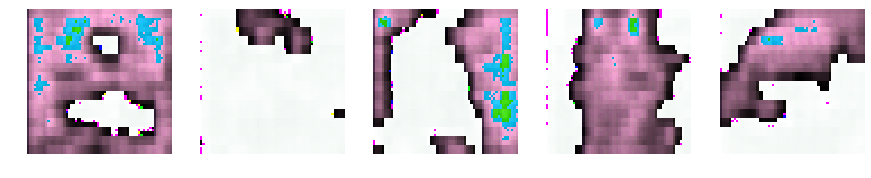

Epoch 4 /15 - loss = 4612.51736328125


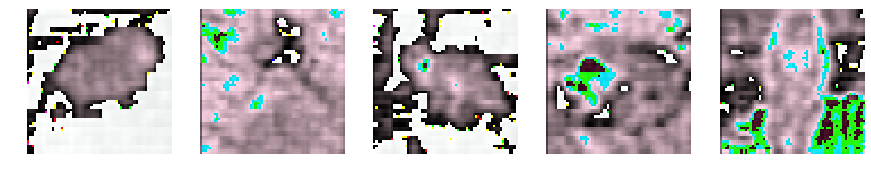

Epoch 5 /15 - loss = 973.4184375


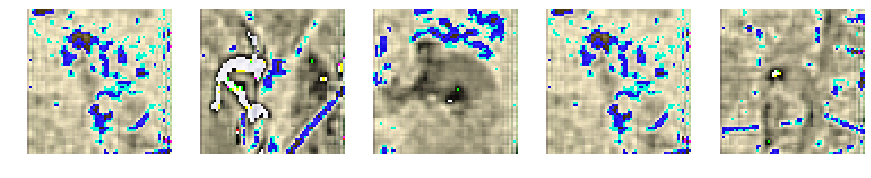

Epoch 6 /15 - loss = 666.0832763671875


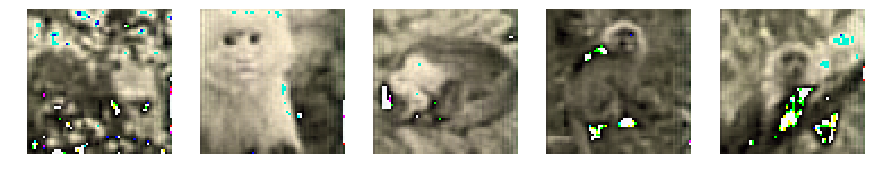

Epoch 7 /15 - loss = 433.49195556640626


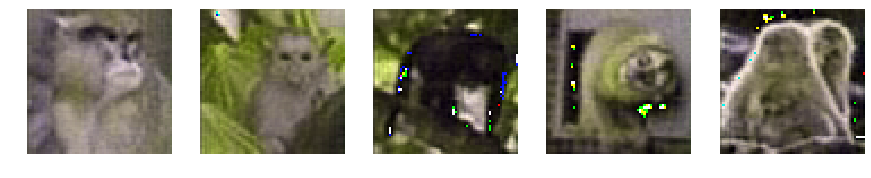

Epoch 8 /15 - loss = 228.28152587890625


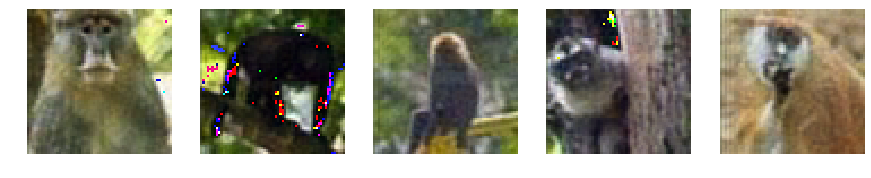

Epoch 9 /15 - loss = 180.48000732421875


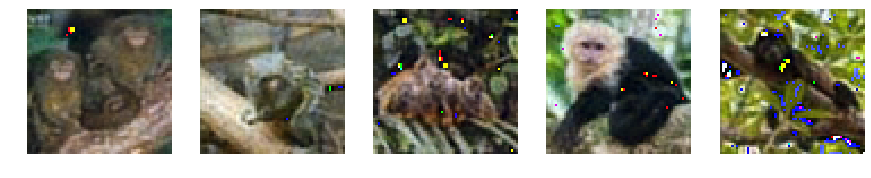

Epoch 10 /15 - loss = 144.21818969726561


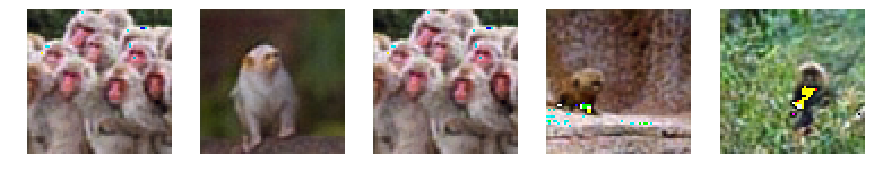

Epoch 11 /15 - loss = 130.9213397216797


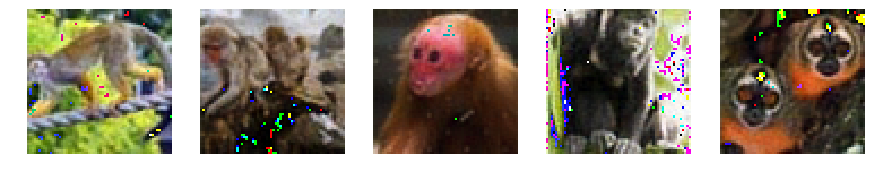

Epoch 12 /15 - loss = 130.21433227539063


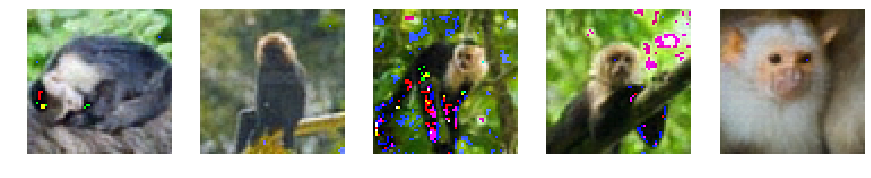

Epoch 13 /15 - loss = 119.74327270507813


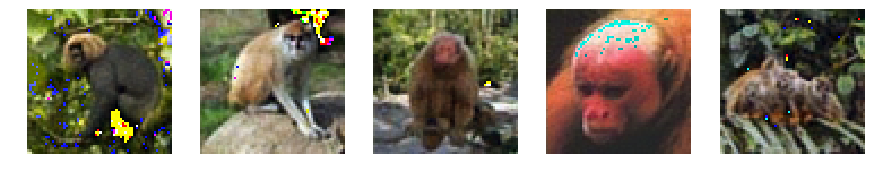

Epoch 14 /15 - loss = 114.59490966796875


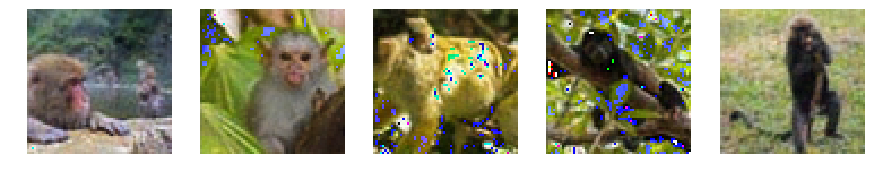

Epoch 15 /15 - loss = 106.32733673095703


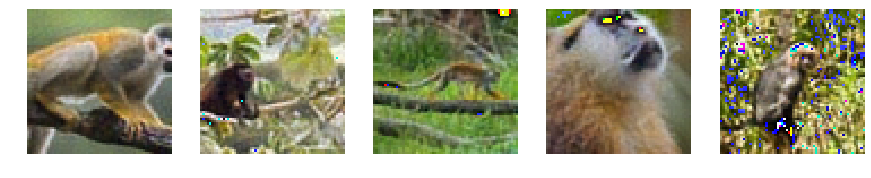

In [9]:
# TRAINING DATA
train = np.zeros((INPUT_DATA_LENGTH,INPUT_DATA_LENGTH))
for i in range(INPUT_DATA_LENGTH): train[i,i] = 1
zeros = np.zeros((INPUT_DATA_LENGTH,INPUT_DENSE))

# TRAIN NETWORKS
ep = 1; it = 15
if BadMemory: lr = 0.01
else: lr = 5.
    
for k in range(it):  

    # BEGIN DISCRIMINATOR COACHES GENERATOR
    annealer = LearningRateScheduler(lambda x: lr)
    h = gan.fit(train, zeros, epochs = ep, batch_size=BATCH_SIZE, callbacks=[annealer], verbose=0)

    # DISPLAY GENERATOR LEARNING PROGRESS 
    print('Epoch',(k+1),'/'+str(it)+' - loss =',h.history['loss'][-1] )
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((INPUT_DATA_LENGTH))
        xx[np.random.randint(INPUT_DATA_LENGTH)] = 1
        plt.subplot(1,5,j+1)
        img = generator.predict(xx.reshape((-1,INPUT_DATA_LENGTH)))[0].reshape((-1,64,64,3))
        img = Image.fromarray( (img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()  
            
    # ADJUST LEARNING RATES
    if BadMemory:
        ep *= 2
        if ep>=32: lr = 0.001
        if ep>256: ep = 256
    else:
        if h.history['loss'][-1] < 25: lr = 1.
        if h.history['loss'][-1] < 1.5: lr = 0.5

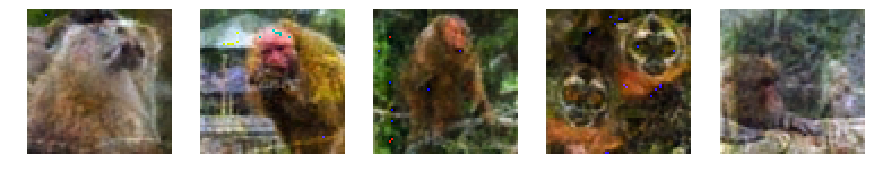

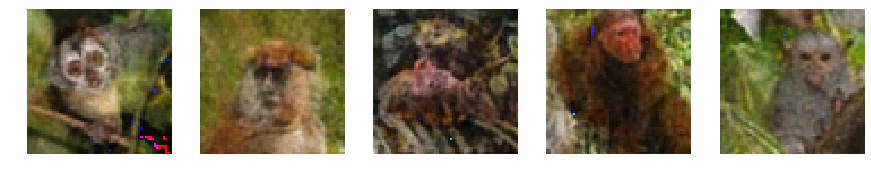

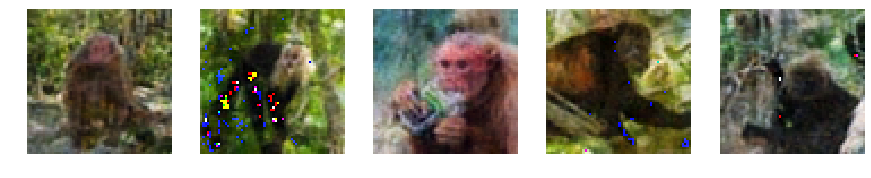

In [10]:
class MonkeyGenerator:
    index = 0   
    def getMonkey(self,seed):
        xx = np.zeros((INPUT_DATA_LENGTH))
        xx[self.index] = 0.70
        xx[np.random.randint(INPUT_DATA_LENGTH)] = 0.30
        img = generator.predict(xx.reshape((-1,INPUT_DATA_LENGTH)))[0].reshape((64,64,3))
        self.index = (self.index+1)%1000
        return Image.fromarray( img.astype('uint8') )
    
# DISPLAY EXAMPLE DOGS
d = MonkeyGenerator()
for k in range(3):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = d.getMonkey(np.random.normal(0,1,100))
        plt.axis('off')
        plt.imshow(img)
    plt.show() 